---
# NOTEBOOK 4 - SECOND-ROUND MODELING
---

# Project 3:
# 'Wait, was that a joke?' - Language Model Identification of Absurdist Humor and Satire
## Daniel Rossetti

# Problem Statement:
This project is conducted from the standpoint of a data scientist hired by a university researching the relatability of AI chat bots and their ability to identify nuances of human language, particularly humor.  Some statements are considered funny, but are not necessarily presented as a joke.  The task is to come up with a language model that can identify humorous strings of text which are not structed in the format of a joke but are of similar structure to factual information.  Text must sourced to train and test a model which can differentiate between humorous and non-humorous statements.

# Project Approach:
The Onion is a satirical news organization which produces news titles and news stories often relevant to real, current events that are satirical or would otherwise be classified as absurdist humor.  For clarity **news articles and titles from The Onion are not real.**  The tiles are however, formated in the format of actual news titles and articles which, from legitimate news agencies - are not humorous.

Comparing the titles of posts to the subreddit r/TheOnion against the subreddit r/worldnews provides a way to compare strings of text which share many of the same formatting characteristics, but have completely different goals with respect to humor.

These subreddits are to be scraped and the data processed to see if a language model can idenifty the humorous Onion titles from the factual World News titles.

# Feature Engineering Approach
With the data now cleaned a few additional steps will be take prior to modeling:
* Word counts for each post will be examined
* Sentiment scores will be provided for each post
    * Sentiment may be useful in finding language in posts which is not neutral in tone.  This may serve to identify posts from The Onion which will stray from the use of neutral lanugage for the sake of satire or absurdism
* Subjectivity scores will also be examined:
    * Subjectivity in-essence describes when a post is opinion-based (subjective).  While best practices for legitimate news agencies are to use neutral language (objective), the words used in posts from The Onion may be more subjective in nature for the sake of satire or absurdism

If these features appear to be capable of increasing model perofrmance, they will be incorporated into the ensemble models.

# Modeling Approach

The final cleaned data output from the previous notebook will be imported and split into training and testing datasets.  The unseen 'holdout' data will also be imported and run alongside the models as a benchmmark.

The testing data created will be viewed after each model, and the information gained will be fed back to retrian the model or explore other features.  On it's own, this would create a dat leakage concenr, which is why the unseen data are provided to maintain the integrity of the modeling process, but also allow for retraining.



# CONTENT WARNING - INAPPROPRIATE LANGUAGE
The folowing should be noted before continuing with this notebook:
* The subreddit posts collected (and therefore shown or presented in these notebooks) may contian profanity or vulgarities, or be otherwise NSFW (Not Safe for Work) due to the fact that the posts are collected before the subreddit mderators can remove them, and that The Onion commonly uses this language for the sake of humor
* The subreddit posts were not generated by the author of this project/notebooks and do not represent his opinions


---
# 1 - Import Packages and Read Data

In [11]:
# STANDARD IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREP
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# LANGUAGE DATA PREP
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# MODELS:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

# METRICS & VISUALIZATIONS
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             recall_score, precision_score)

from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

In [8]:
# Source to reset pandas column width:  https://pandas.pydata.org/docs/reference/api/pandas.reset_option.html
# Source to widen pandas columns:  https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.reset_option('all')
pd.set_option('display.max_colwidth', 200)

C:\Users\Dan\AppData\Local\Temp\ipykernel_21560\2892979834.py:3: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
C:\Users\Dan\AppData\Local\Temp\ipykernel_21560\2892979834.py:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
C:\Users\Dan\AppData\Local\Temp\ipykernel_21560\2892979834.py:3: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


In [9]:
# Rad in the Modeling Data
reddit = pd.read_csv('../data/reddit_clean_2.csv')
reddit

,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News
4,TheOnion,Dog And Owner Having Public Fight
...,...,...
10043,worldnews,Diners in Japan arrested for dipping own chopsticks in communal bowl of ginger
10044,worldnews,200 Russian Journalists Sign Letter Demanding US Reporters Release
10045,worldnews,Foxconn founder Gou to run for Taiwan presidency again
10046,worldnews,A wartime NATO struggles to replace its chief


In [10]:
holdout = pd.read_csv('../data/reddit_holdout_2.csv')
holdout

,subreddit,title
0,TheOnion,US Schools Trail World In Child Soldier Aptitude
1,TheOnion,Is Your Flamingo Sick Enough To Make A Movie About
2,TheOnion,More American Workers Outsourcing Own Jobs Overseas
3,TheOnion,So People Could Be Listening To This Conversation Right Now Asks Joe Rogan Trying To Understand Edward Snowdens Explanation Of Surveillance
4,TheOnion,Destroyed substitute teachers
...,...,...
1722,worldnews,High level of activity spotted at North Koreas key nuclear complex
1723,worldnews,For the first time renewable energy generation beat out coal in the US
1724,worldnews,Chinas loans to Africa worry World Bank President David Malpass
1725,worldnews,In Ukraine where even the corpses are booby trapped Canada is helping soldiers stay alive


# 2 - Feature Engineering

## 2.1 - Word Counts

In [4]:
# Read in the Model Data
reddit = pd.read_csv('../data/reddit_clean_2.csv')
reddit

,subreddit,title
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty F...
1,TheOnion,New Texas Law Requires Schools To Display Imag...
2,TheOnion,New Poll Finds Americans Would Respect Biden M...
3,TheOnion,Could You Pass Racial Discrimination Training ...
4,TheOnion,Dog And Owner Having Public Fight
...,...,...
10043,worldnews,Diners in Japan arrested for dipping own chops...
10044,worldnews,200 Russian Journalists Sign Letter Demanding ...
10045,worldnews,Foxconn founder Gou to run for Taiwan presiden...
10046,worldnews,A wartime NATO struggles to replace its chief


In [5]:
# Read in the Holdout Data
holdout = pd.read_csv('../data/reddit_holdout_2.csv')
holdout

,subreddit,title
0,TheOnion,US Schools Trail World In Child Soldier Aptitude
1,TheOnion,Is Your Flamingo Sick Enough To Make A Movie A...
2,TheOnion,More American Workers Outsourcing Own Jobs Ove...
3,TheOnion,So People Could Be Listening To This Conversat...
4,TheOnion,Destroyed substitute teachers
...,...,...
1722,worldnews,High level of activity spotted at North Koreas...
1723,worldnews,For the first time renewable energy generation...
1724,worldnews,Chinas loans to Africa worry World Bank Presid...
1725,worldnews,In Ukraine where even the corpses are booby tr...


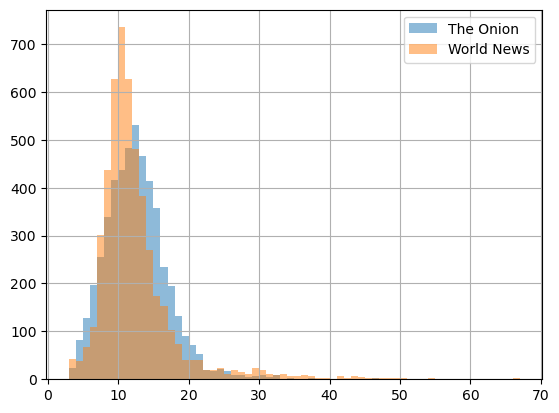

In [28]:
# Use a lambda funciton and the split method to get word counts
# Filter for each reddit and plot a histogram
onion_word_counts = reddit['title'].apply(lambda word: len(word.split(' ')))[reddit['subreddit'] == 'TheOnion']
wldnws_word_counts = reddit['title'].apply(lambda word: len(word.split(' ')))[reddit['subreddit'] == 'worldnews']

onion_word_counts.hist(alpha = 0.5, bins = (onion_word_counts.max() - onion_word_counts.min()));
wldnws_word_counts.hist(alpha = 0.5, bins = (wldnws_word_counts.max() - wldnws_word_counts.min()));
plt.legend(['The Onion', 'World News']);

In [32]:
onion_word_counts.describe(), wldnws_word_counts.describe()

(count    5043.000000
 mean       12.124727
 std         4.553454
 min         3.000000
 25%         9.000000
 50%        12.000000
 75%        15.000000
 max        50.000000
 Name: title, dtype: float64,
 count    5005.000000
 mean       12.014186
 std         5.874520
 min         3.000000
 25%         9.000000
 50%        11.000000
 75%        13.000000
 max        67.000000
 Name: title, dtype: float64)

In [35]:
# Create a separate dataframe to create word count column and encode the target variable
#  This way, it won't have to be undone later ... in retrospect, this was more work
word_count_tester = reddit
word_count_tester['w_counts'] = word_count_tester['title'].apply(lambda word: len(word.split(' ')))
word_count_tester['target'] = word_count_tester['subreddit'].map({'TheOnion': 1, 'worldnews':0})
word_count_tester.corr()

C:\Users\Dan\AppData\Local\Temp\ipykernel_21560\1753397471.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  word_count_tester.corr()


,w_counts,target
w_counts,1.000000,0.010522
target,0.010522,1.000000


#### OBSERVATIONS:
* Average word counts are about the same for both The Onion and World News titles
* The World News titles have a more varried spread compared to The Onion.  This is reflected in both the standard deviation and the overall spread of the word counts
* There is little to no correlation between the word counts and the subreddit

Overall, the length of the title should have little to do with whether or not a title is funny, so there is really little justification to including this feature in the model. 

## 2.2 - Sentiment Analysis
It is possible that the word choice of Onion news titles may have more emotional verbiage for the sake of humor and satire.  By examining the compound sentiment scores for each title, it may be possible to determine if a title is from The Onion if the tiels have more emotional content.  Hihger sentiment scores indicate more positivity, and lower sentiment scores indicate more negativity with 0 being neutral.

In [37]:
# Instantiate Sentiment Analyzer
sent = SentimentIntensityAnalyzer()

# Create a column with the compound polarity score for each title
reddit['sentiment'] = reddit['title'].apply(lambda title: sent.polarity_scores(title)['compound'])
reddit.head()

,subreddit,title,w_counts,target,sentiment
0,TheOnion,Idiot Tornado Tears Harmlessly Through Empty Field,7,1,-0.5574
1,TheOnion,New Texas Law Requires Schools To Display Image Of God Hung Like A Horse In Every Classroom,17,1,0.5574
2,TheOnion,New Poll Finds Americans Would Respect Biden More If He Shot Them,12,1,0.4767
3,TheOnion,Could You Pass Racial Discrimination Training At Fox News,9,1,0.0000
4,TheOnion,Dog And Owner Having Public Fight,6,1,-0.3818


In [38]:
reddit[reddit['subreddit'] == 'TheOnion']['sentiment'].describe()

count    5043.000000
mean       -0.037135
std         0.409122
min        -0.947100
25%        -0.340000
50%         0.000000
75%         0.240100
max         0.937100
Name: sentiment, dtype: float64

In [39]:
reddit[reddit['subreddit'] == 'worldnews']['sentiment'].describe()

count    5005.000000
mean       -0.161563
std         0.402787
min        -0.969000
25%        -0.510600
50%         0.000000
75%         0.000000
max         0.963300
Name: sentiment, dtype: float64

In [40]:
reddit[['target', 'sentiment']].corr()

,target,sentiment
target,1.00000,0.15149
sentiment,0.15149,1.00000


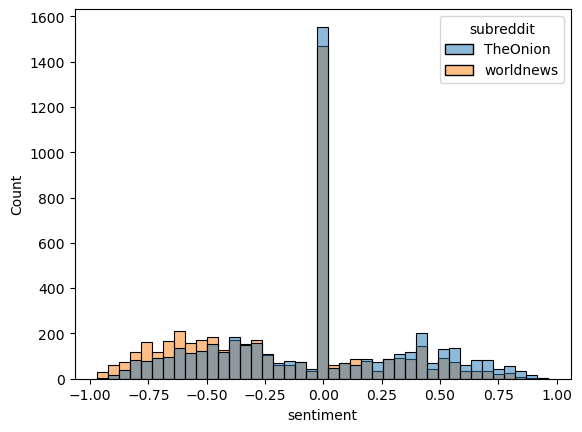

In [49]:
# Plot a histogram using seaborn
# Help with this from the following sourece:  https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(reddit, x =reddit['sentiment'],  hue = 'subreddit');

#### OBSERVATIONS:
* The mean compound sentiment score for the world news titles are more negative than that of the Onion which interstingly, is closer to 0.  The opposite was thought to be true, that perhaps the actual news would have a more neutral delivery than The Onion
* Correlation between sentiment and the subreddit is very weak, but stronger than word counts

This feature should be included later in an ensemble model to determine if it would increase model performance

## <font color = 'red'> 2.3 - Subjectivity Analysis

# 3 - Pre-Modeling Steps

## 3.1 - Train Test Split 80/20 Split

In [50]:
# Create X and y variables

# Creating X - for now, this will only include the title data for ease of modeling
X = reddit['title']
y = reddit['target']

In [51]:
y.value_counts(normalize=True)

1    0.501891
0    0.498109
Name: target, dtype: float64

In [52]:
# Run the train test split, no need to stratify as classes are very even
#  Select an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

## 3.2 - Word Vectorizing

### 3.2.1 - CountVectorizer

In [95]:
def word_plotter(word_vec, X_var, y_var, num_words):
    
    # Create vectorized data
    X_train_cvec = word_vec.fit_transform(X_var)
    
    # Create dataframe from vecotrized data
    cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = word_vec.get_feature_names_out())
    
    # Add the target variable to filer, but reset the index
    cvec_df['0000_target'] = y_var.reset_index(drop = True)
    
    # Plot it out!
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    cvec_df[cvec_df['0000_target'] == 0].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(num_words).plot.barh();
    plt.title('World News')
    plt.subplot(1, 2, 2)
    cvec_df[cvec_df['0000_target'] == 1].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(num_words).plot.barh();
    plt.title('The Onion')

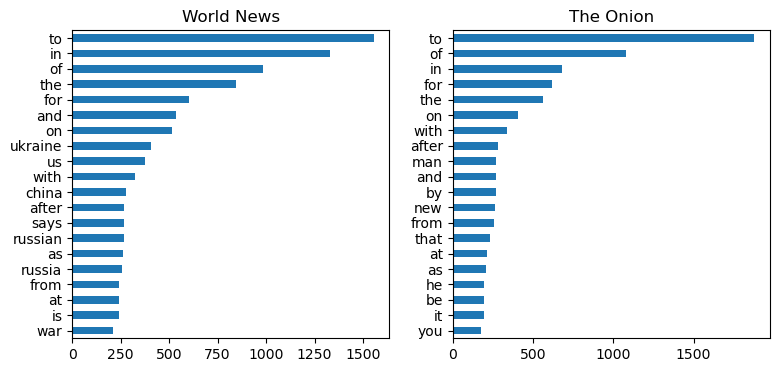

In [96]:
word_plotter(CountVectorizer(), X_train, y_train, 20)

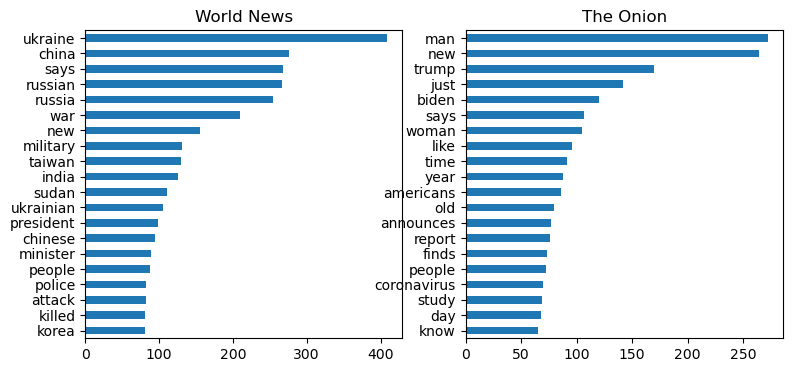

In [97]:
word_plotter(CountVectorizer(stop_words='english'), X_train, y_train, 20)

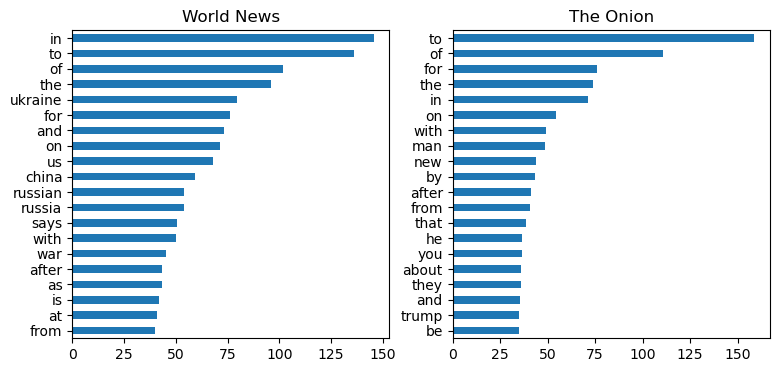

In [98]:
word_plotter(TfidfVectorizer(), X_train, y_train, 20)

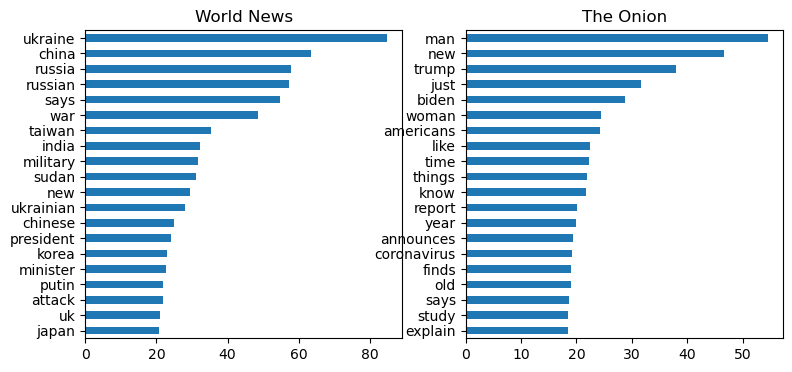

In [99]:
word_plotter(TfidfVectorizer(stop_words='english'), X_train, y_train, 20)

#### OBERSEVATIONS:
* A noted source of error is that in the word pre-processing, U.S. may have been shortened to 'us'.  When stop words are removed, this word is clearly missing from the plots

In [78]:
# Instantiat CountVectoirzer
cvec = CountVectorizer()

# Create a new dataframe from the fit data, and include the target variable for analysis
X_train_cvec = cvec.fit_transform(X_train)
cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names_out())
cvec_df['0000_target'] = y_train.reset_index(drop = True)
cvec_df.head(2)

,000,04,05,07,10,100,1000,10000,100000,100th,...,zookeepers,zoologists,zoom,zorb,zowie,zuckerberg,zuckerbergs,zurich,â55bn,0000_target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'World News')

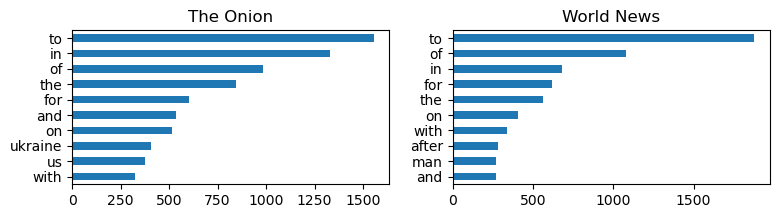

In [84]:
plt.figure(figsize=(9, 2))
plt.subplot(1, 2, 1)
cvec_df[cvec_df['0000_target'] == 0].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(10).plot.barh();
plt.title('The Onion')
plt.subplot(1, 2, 2)
cvec_df[cvec_df['0000_target'] == 1].drop(columns = '0000_target').sum().T.sort_values( ascending= True).tail(10).plot.barh();
plt.title('World News')

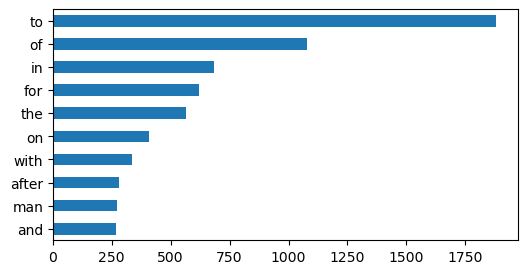

In [77]:
# Instantiat CountVectoirzer
cvec = CountVectorizer()

# Create a new dataframe from the fit data, and include the target variable for analysis
X_train_cvec = cvec.fit_transform(X_train)
cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names_out())
cvec_df['0000_target'] = y_train.reset_index(drop = True)
cvec_df.head(2)